### Tarea 2

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer, EarlyStopping

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')

        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding


class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()

    @staticmethod
    def visualize_learned_positional_encoding(pos_embedding: torch.Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales Aprendidas', fontsize=16, weight='bold')
        for i in range(pos_embedding.shape[2]):
            plt.plot(pos_embedding[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor del Embedding', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()



def pipeline(patch_size, embed_dim, patch_idx, use_learned_encoded=False):
    # Parámetros
    img_path = "raccoon.jpg"
    img_size = 900


    # Preprocesamiento
    config = ConfigPreprocess(img_path, img_size, patch_size)

    # Extracción de parches y visualización
    patches = config.extract_patches(config.test_img.squeeze(0))
    Visualization.visualize_patches(patches)

    # Generación de embeddings
    embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
    patches = embedded_patches(config.test_img)

    # Codificación posicional
    num_patches = (img_size // patch_size) ** 2
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim) if use_learned_encoded else PositionalEncoding(num_patches, embed_dim)


    positional_encoding = positional_encoding.to(config.device)
    pos_embeddings = positional_encoding(patches)
    if use_learned_encoded:
        Visualization.visualize_learned_positional_encoding(pos_embeddings)
    else:
        Visualization.visualize_positional_encoding(pos_embeddings)
    Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)




1) Implementar la arquitectura de un Vision Transformer

In [2]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  cuda
Torch version:  2.6.0+cu124


In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

In [40]:
# Define transformations for the input data


#data augmentation 2
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(32, scale=(0.7, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
#     transforms.RandomErasing(p=0.3)
# ])

#data augmentation 3
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    transforms.RandomErasing(p=0.1)
])



# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

In [41]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=128, num_heads=4, ff_dim=512, num_layers=6, dropout=0.1,
                 batch_first=True, use_learned_encoding=False):
        super(VisionTransformer, self).__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.use_learned_encoding = use_learned_encoding

        if self.use_learned_encoding:
            self.pos_embedding = PositionalEncodingLearned(num_patches + 1, embed_dim)
        else:
            self.pos_embedding = PositionalEncoding(num_patches + 1, embed_dim)

        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B = x.shape[0]

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.pos_embedding(x)

        x = self.encoder(x)
        x = self.norm(x)
        return self.head(x[:, 0])


In [42]:
'''
A continuacion ingrese los parametros del modelo

'''

num_epochs = 50

#primer intento
# model = VisionTransformer(
#     img_size=32,
#     patch_size=4,
#     embed_dim=128,
#     num_heads=4,
#     ff_dim=512,
#     num_layers=6,
#     dropout=0.1,
#     batch_first=True
# ).to(device)

# Accuracy: 0.10
# Precision: 0.01
# Recall: 0.10
# F1 score: 0.02


#segundo intento
# model = VisionTransformer(
#     img_size=32,
#     patch_size=4,
#     embed_dim=64,
#     num_heads=2,
#     ff_dim=256,
#     num_layers=4,
#     dropout=0.2,
#     batch_first=True
# ).to(device)


# Accuracy: 0.10
# Precision: 0.01
# Recall: 0.10
# F1 score: 0.02
#scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
#optimizer = optim.AdamW(model.parameters(), lr=3e-4)

#tercer intento
#epoch 50
num_epochs = 50
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=128,
    num_heads=4,
    ff_dim=512,
    num_layers=6,
    dropout=0.1,
    batch_first=True,
    use_learned_encoding=True
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print("Parametros del modelo:", list(model.parameters()))


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

Parametros del modelo: [Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[[[ 0.0532, -0.1382, -0.0060, -0.0985],
          [ 0.0723, -0.1017, -0.0755, -0.0824],
          [-0.0279, -0.1335,  0.0026,  0.0763],
          [-0.0555,  0.0920, -0.1030,  0.1289]],

         [[ 0.0248,  0.1003, -0.0794, -0.0153],
          [ 0.0882, -0.1242,  0.0626,  0.0072],
          [ 0.0710,  0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [43]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


In [44]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 1.20 millones


In [49]:
early_stopper = EarlyStopping(patience=5)

trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)
for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    losses = trainer.eval_model()
    scheduler.step()
    if early_stopper(model, losses):
        print("⏹️ Early stopping triggered.")
        break

val_loss 2.30254: 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]

⏹️ Early stopping triggered.


In [51]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

# Evaluar el modelo
print(model)
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_embedding): PositionalEncodingLearned()
    (encoder): TransformerEncoder(
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=False)
            )
            (linear1): Linear(in_features=128, out_features=512, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=128, bias=False)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
      

100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


In [56]:
train_dataset.data[0].shape

(32, 32, 3)

In [57]:
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

  0%|          | 0/20 [00:00<?, ?it/s]


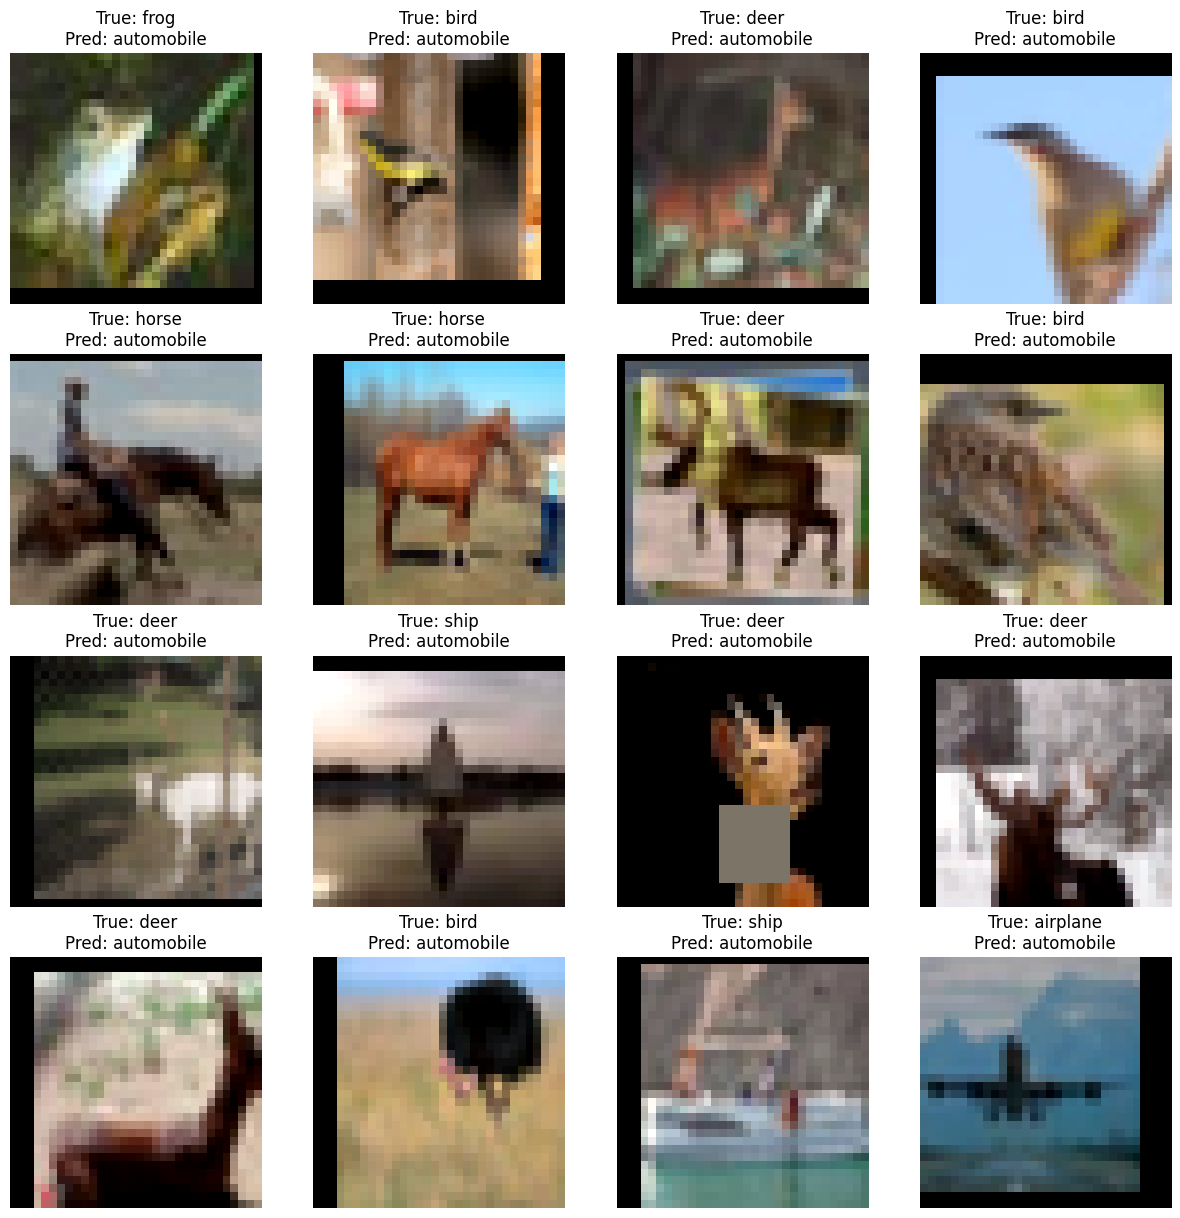

In [58]:


def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()